# Rating Prediction from Reviews

This notebook builds models to predict the rating a user gave to a product based on their review text and structured metadata. We use both TF-IDF vectors and engineered features to train and evaluate classification models.

In [1]:
# Rating Prediction from Reviews

# This notebook builds models to predict product ratings based on review text and structured metadata.
# It includes both binary classification (1–2 stars vs 4–5 stars) and regression (predicting exact rating).

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    mean_absolute_error, mean_squared_error, roc_auc_score
)
from imblearn.over_sampling import SMOTE
from scipy.sparse import hstack
import joblib

In [2]:
df = pd.read_parquet("/content/engineered_features.parquet")
X_tfidf = joblib.load("/content/X_tfidf_vectorized.pkl")
print(" Data loaded:", df.shape)

 Data loaded: (9480, 47)


In [3]:
# Filter for binary classes: 1–2 stars → 0, 4–5 stars → 1
df = df[df['reviews.rating'].isin([1, 2, 4, 5])].copy()
df['binary_rating'] = df['reviews.rating'].apply(lambda x: 0 if x <= 2 else 1)

In [4]:
structured_features = [
    # Textual and behavioral
    'review_length', 'sentiment_polarity', 'repetition_score',

    # Engagement and helpfulness
    'log_helpful', 'no_helpful_votes_flag', 'helpful_missing_flag',

    # Purchase and recommendation signals
    'purchase_encoded', 'recommend_encoded',
    'purchase_missing_flag', 'recommend_missing_flag',

    # Metadata and semantic alignment
    'username_dup_flag', 'multi_review_same_day_flag', 'multi_review_same_product_flag',
    'product_name_match_flag', 'unrelated_product_flag', 'semantic_mismatch_score',

    # Categorical encodings
    'brand_encoded', 'category_group_encoded'
]

X_structured = df[structured_features].values
X_tfidf_filtered = X_tfidf[df.index]  # Align TF-IDF with filtered df
X_combined = hstack([X_tfidf_filtered, X_structured])
y = df['binary_rating'].values

Rating distribution:
 binary_rating
0    0.039426
1    0.960574
Name: proportion, dtype: float64


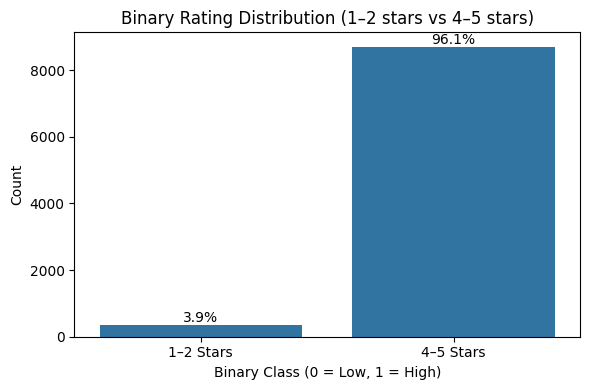

In [5]:
rating_counts = df['binary_rating'].value_counts(normalize=True).sort_index()
print("Rating distribution:\n", rating_counts)

plt.figure(figsize=(6, 4))
ax = sns.countplot(x='binary_rating', data=df)
plt.title("Binary Rating Distribution (1–2 stars vs 4–5 stars)")
plt.xlabel("Binary Class (0 = Low, 1 = High)")
plt.ylabel("Count")
plt.xticks([0, 1], ["1–2 Stars", "4–5 Stars"])

# Add percentages
total = len(df)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{100 * height / total:.1f}%',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
print("Before SMOTE:")
print(df['binary_rating'].value_counts())

Before SMOTE:
binary_rating
1    8698
0     357
Name: count, dtype: int64


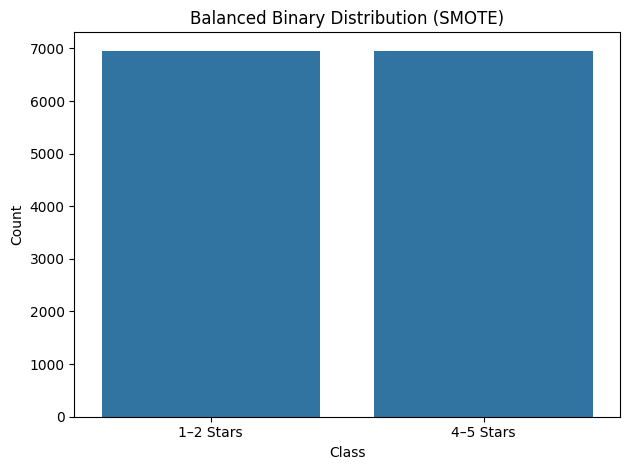

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, train_size=0.8, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test, random_state=42)

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

sns.countplot(x=y_train_resampled)
plt.title("Balanced Binary Distribution (SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks([0, 1], ["1–2 Stars", "4–5 Stars"])
plt.tight_layout()
plt.show()

In [8]:
print("After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

After SMOTE:
1    6958
0    6958
Name: count, dtype: int64


In [9]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42)
clf.fit(X_train_resampled, y_train_resampled)

test_pred = clf.predict(X_test)
val_pred = clf.predict(X_val)

print("Test Accuracy:", accuracy_score(y_test, test_pred))
print("Validation Accuracy:", accuracy_score(y_val, val_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, test_pred, zero_division=0))

print("\nValidation Classification Report:")
print(classification_report(y_val, val_pred, zero_division=0))

print("\nConfusion Matrix (Test):")
print(confusion_matrix(y_test, test_pred))

print("\nConfusion Matrix (Validation):")
print(confusion_matrix(y_val, val_pred))

# ROC-AUC
probs = clf.predict_proba(X_test)[:, 1]
print("Test ROC-AUC:", roc_auc_score(y_test, probs))

Test Accuracy: 0.9792817679558011
Validation Accuracy: 0.977961432506887

Test Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.53      0.67        57
           1       0.98      1.00      0.99      1391

    accuracy                           0.98      1448
   macro avg       0.95      0.76      0.83      1448
weighted avg       0.98      0.98      0.98      1448


Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.43      0.60        14
           1       0.98      1.00      0.99       349

    accuracy                           0.98       363
   macro avg       0.99      0.71      0.79       363
weighted avg       0.98      0.98      0.97       363


Confusion Matrix (Test):
[[  30   27]
 [   3 1388]]

Confusion Matrix (Validation):
[[  6   8]
 [  0 349]]
Test ROC-AUC: 0.9624780859409486


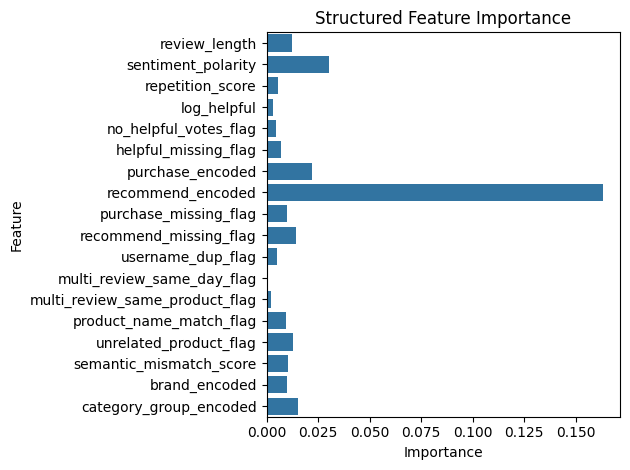

In [10]:
importances = clf.feature_importances_[-len(structured_features):]
sns.barplot(x=importances, y=structured_features)
plt.title("Structured Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [11]:
joblib.dump(clf, "binary_rating_classifier_SMOTE.pkl")

['binary_rating_classifier_SMOTE.pkl']

## Rating Prediction via Regression


## Rating Prediction with Regression

In this section, we treat `reviews.rating` as a continuous variable and use regression to predict it. This approach may capture subtle differences between ratings and reduce confusion between adjacent classes.

In [12]:
y_reg = df['reviews.rating'].astype(float)

In [13]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_combined, y_reg, train_size=0.8, random_state=42)
X_test_reg, X_val_reg, y_test_reg, y_val_reg = train_test_split(X_test_reg, y_test_reg, train_size=0.8, random_state=42)

In [14]:
reg = GradientBoostingRegressor(random_state=42)
reg.fit(X_train_reg, y_train_reg)

GradientBoostingRegressor(random_state=42)

In [15]:
y_pred_test = reg.predict(X_test_reg)
y_pred_val = reg.predict(X_val_reg)

In [16]:
print("Test MAE:", mean_absolute_error(y_test_reg, y_pred_test))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test_reg, y_pred_test)))

Test MAE: 0.41683238423524144
Test RMSE: 0.531482101957447


In [17]:
print("Validation MAE:", mean_absolute_error(y_val_reg, y_pred_val))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_val_reg, y_pred_val)))

Validation MAE: 0.39575437789331863
Validation RMSE: 0.4940465329920905


In [18]:
# Round predictions for classification-style evaluation
y_pred_test_rounded = np.clip(np.round(y_pred_test), 1, 5).astype(int)
y_test_true = y_test_reg.astype(int)

In [19]:
print("\nRounded Classification Report (Test):")
print(classification_report(y_test_true, y_pred_test_rounded, zero_division=0))


Rounded Classification Report (Test):
              precision    recall  f1-score   support

           1       0.82      0.20      0.32        45
           2       0.24      0.42      0.31        24
           3       0.00      0.00      0.00         0
           4       0.71      0.36      0.48       446
           5       0.75      0.93      0.83       933

    accuracy                           0.73      1448
   macro avg       0.51      0.38      0.39      1448
weighted avg       0.74      0.73      0.70      1448



In [20]:
print("Confusion Matrix (Test):")
print(confusion_matrix(y_test_true, y_pred_test_rounded))

Confusion Matrix (Test):
[[  9  27   5   4   0]
 [  2  10   7   2   3]
 [  0   0   0   0   0]
 [  0   2   2 162 280]
 [  0   2   1  59 871]]


In [21]:
joblib.dump(reg, "rating_prediction_regressor.pkl")

['rating_prediction_regressor.pkl']

save plots

In [22]:
vectorizer = joblib.load("/content/tfidf_vectorizer.pkl")

In [23]:
plt.savefig("binary_rating_distribution.png")

<Figure size 640x480 with 0 Axes>

In [24]:
plt.savefig("smote_balanced_distribution.png")

<Figure size 640x480 with 0 Axes>

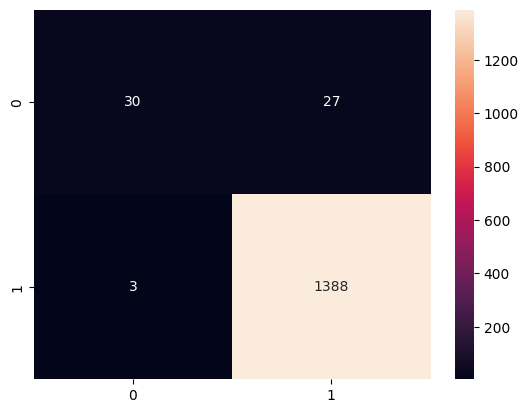

In [25]:
sns.heatmap(confusion_matrix(y_test, test_pred), annot=True, fmt='d')
plt.savefig("confusion_matrix_test.png")

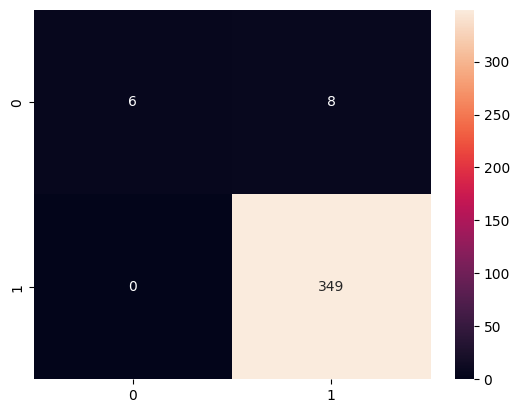

In [26]:
sns.heatmap(confusion_matrix(y_val, val_pred), annot=True, fmt='d')
plt.savefig("confusion_matrix_val.png")

In [27]:
plt.savefig("structured_feature_importance.png")

<Figure size 640x480 with 0 Axes>

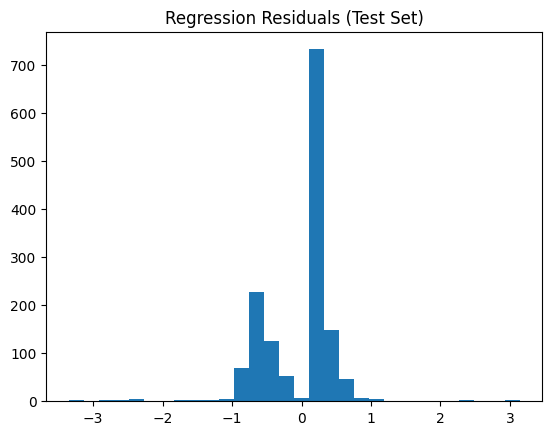

In [28]:
plt.hist(y_test_reg - y_pred_test, bins=30)
plt.title("Regression Residuals (Test Set)")
plt.savefig("regression_residuals_test.png")

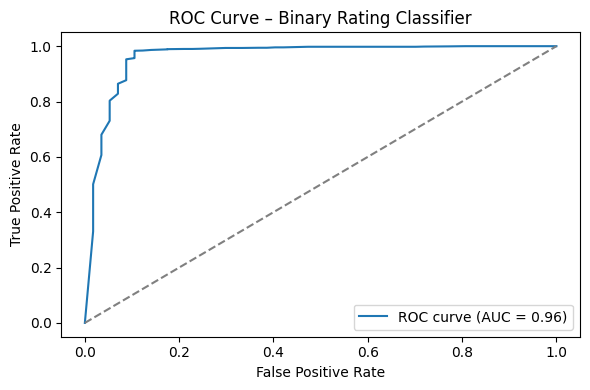

In [29]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Binary Rating Classifier")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_binary_rating.png")

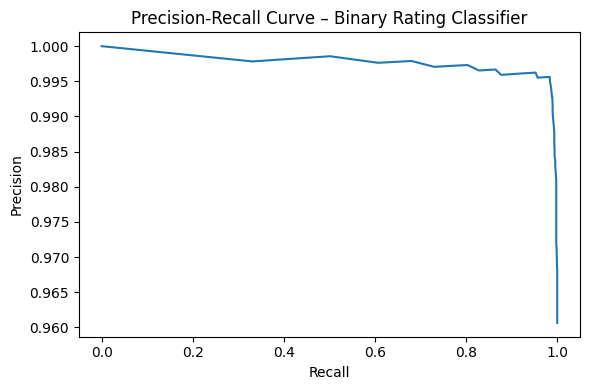

In [30]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, probs)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve – Binary Rating Classifier")
plt.tight_layout()
plt.savefig("precision_recall_curve.png")

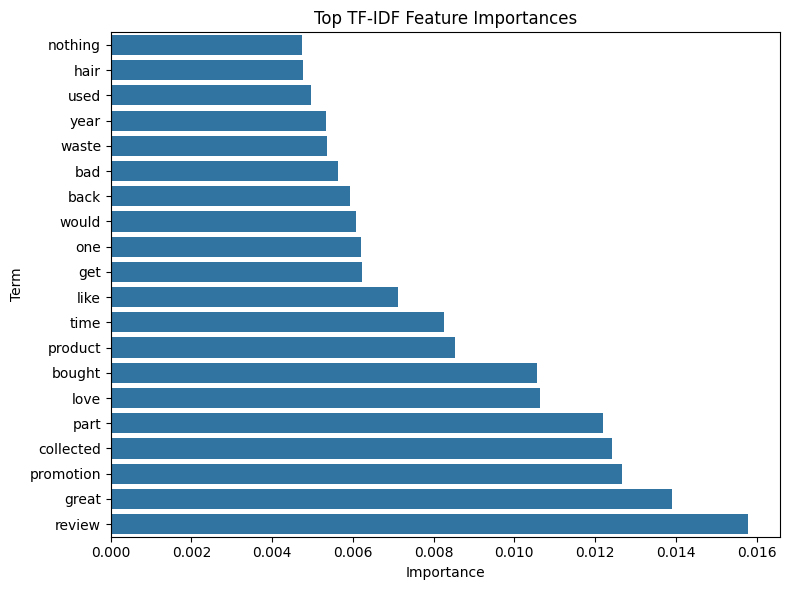

In [31]:
#
structured_importances = clf.feature_importances_[-len(structured_features):]
tfidf_importances = clf.feature_importances_[:-len(structured_features)]

#
top_n = 20
top_indices = np.argsort(tfidf_importances)[-top_n:]
top_features = np.array(vectorizer.get_feature_names_out())[top_indices]
top_values = tfidf_importances[top_indices]

plt.figure(figsize=(8, 6))
sns.barplot(x=top_values, y=top_features)
plt.title("Top TF-IDF Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Term")
plt.tight_layout()
plt.savefig("tfidf_feature_importance.png")

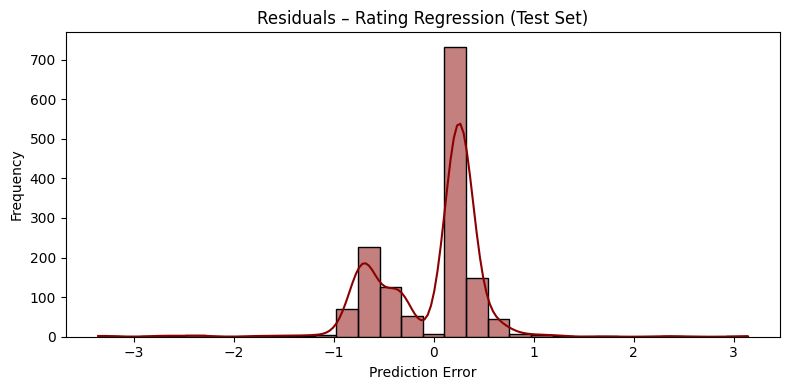

In [32]:
residuals = y_test_reg - y_pred_test

plt.figure(figsize=(8, 4))
sns.histplot(residuals, bins=30, kde=True, color='darkred')
plt.title("Residuals – Rating Regression (Test Set)")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("regression_residuals.png")

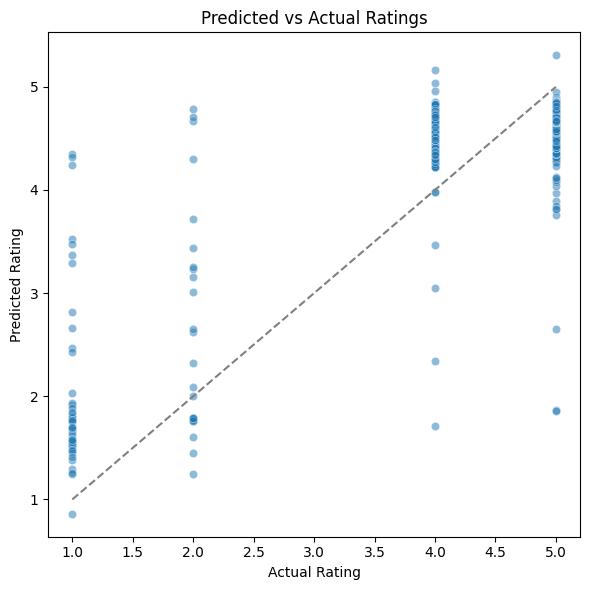

In [33]:
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test_reg, y=y_pred_test, alpha=0.5)
plt.plot([1, 5], [1, 5], color='gray', linestyle='--')
plt.title("Predicted vs Actual Ratings")
plt.xlabel("Actual Rating")
plt.ylabel("Predicted Rating")
plt.tight_layout()
plt.savefig("predicted_vs_actual_ratings.png")

In [34]:
with open("classification_report_test.txt", "w") as f:
    f.write(classification_report(y_test, test_pred, zero_division=0))

In [35]:
pd.Series(importances, index=structured_features).to_csv("structured_feature_importance.csv")